In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import imp
import numpy as np
from scipy import constants

import lsst.daf.persistence as daf_persistence
from lsst.sims.photUtils import Bandpass, PhotometricParameters
from lsst.utils import getPackageDir

In [3]:
def look(img, range=None, x_range=None, y_range=None):
    """Simple function to wrap matplotlib and display an image with a colorbar."""
    plt.figure(figsize=(16, 6))
    if range is None:
        range = [np.min(img), np.max(img)]
    img_use = np.clip(img, range[0], range[1])
    if x_range is not None:
        x0 = int(x_range[0])
        x1 = int(x_range[1])
        if x0 < 0:
            img_use = np.roll(img_use, -x0, axis=1)
            x1 -= x0
            x0 = 0
        img_use = img_use[:, x0: x1]
    if y_range is not None:
        y0 = int(y_range[0])
        y1 = int(y_range[1])
        if y0 < 0:
            img_use = np.roll(img_use, -y0, axis=0)
            y1 -= y0
            y0 = 0
        img_use = img_use[y0: y1, :]
    fig_show = plt.imshow(img_use, interpolation='none', origin='lower', cmap=cm.rainbow)
    plt.colorbar(fig_show, orientation='vertical', shrink=1)
#    cbar.set_label('DCR (arcsec)', labelpad=0)
    plt.show()

In [4]:
repository = "./test_data/"
obsid_range = np.arange(100, 124, 3)
band_name = "g"

In [5]:
# imp.load_source('dcr_template', './python/dcr_template.py')
from python.dcr_template import DcrCorrection
from python.dcr_template import DcrModel

In [21]:
self = DcrCorrection(n_step=3, repository=repository, obsid_range=obsid_range, band_name=band_name,
                     use_psf=False,use_fft=False, debug_mode=True, kernel_size=9)

In [22]:
exp = self.exposures[0]

In [23]:
exp.getMetadata().get("AIRMASS")

2.0

In [24]:
visitInfo = exp.getInfo().getVisitInfo()

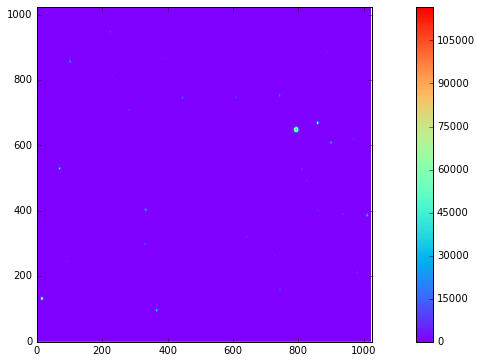

In [25]:
look(exp.getMaskedImage().getImage().getArray())

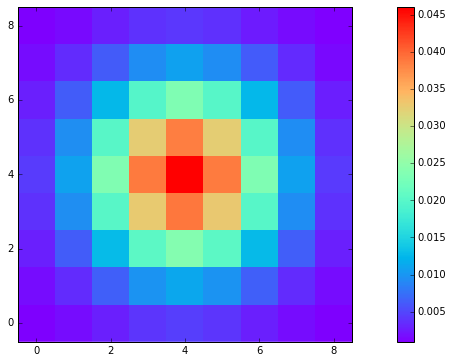

(0.046063199914024154, 0.91131703537121844)


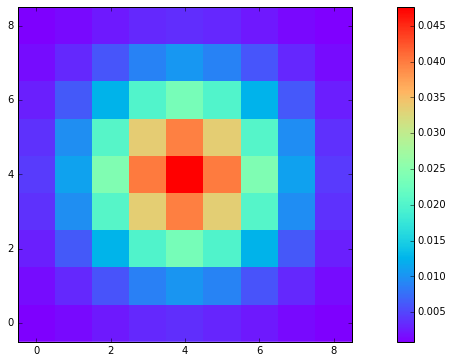

(0.047619745775690163, 0.91293047988848519)


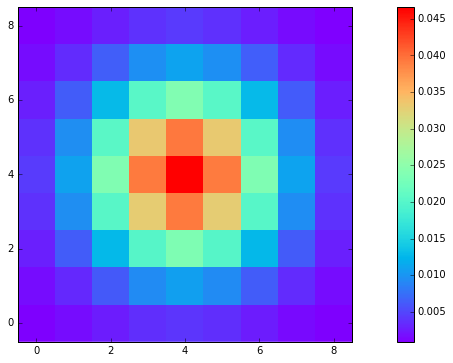

(0.046602726543303316, 0.91792445609584272)
SUM


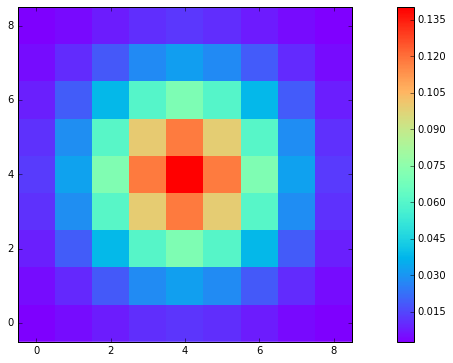

0.140285672233
DIFF


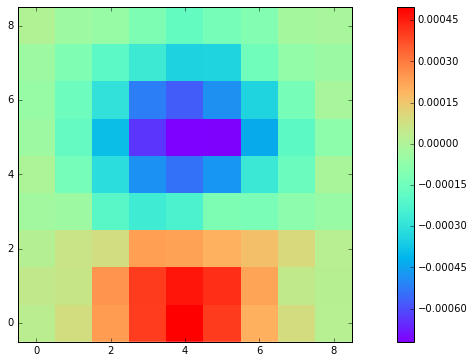

In [26]:
for _i in range(self.n_step):
    look(self.psf_model[_i, :, :])
    print(np.max(self.psf_model[_i, :, :]), np.sum(self.psf_model[_i, :, :]))
print("SUM")
look(np.sum(self.psf_model,axis=0))
print(np.max(np.sum(self.psf_model,axis=0)))
print("DIFF")
look(self.psf_model[0, :, :] - self.psf_model[-1, :, :])

In [27]:
self.build_model(use_full=False, use_regularization=True, use_only_detected=False)

Working on column
 0.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 100.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 200.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 300.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 400.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 500.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 600.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 700.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 800.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 900.........|.........|.........|.........|....

In [28]:
self.export_model(model_repository="/Users/sullivan/LSST/simulations/test5/output_data_test")

In [29]:
x0 = 150
dx = 65
y0 = 480
dy = 70

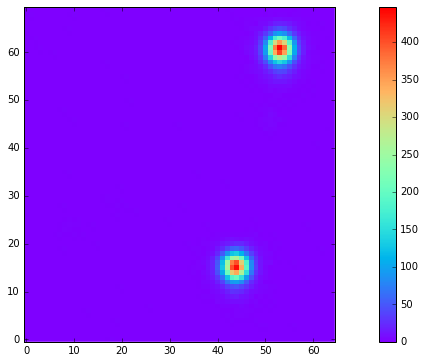

('max: ', 446.93700981046925, 'sum: ', 22140.263079105556)


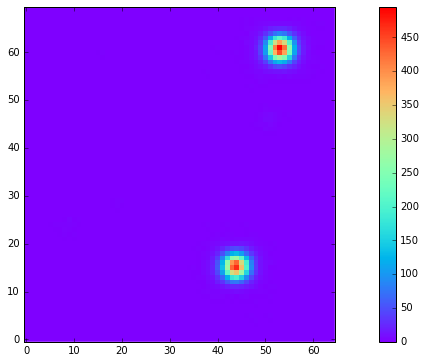

('max: ', 495.0726266985539, 'sum: ', 21525.818706727456)


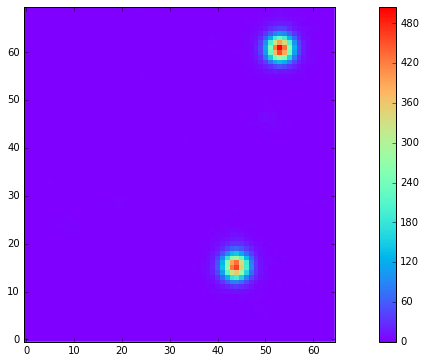

('max: ', 504.858821989153, 'sum: ', 22861.678280367614)
SUM


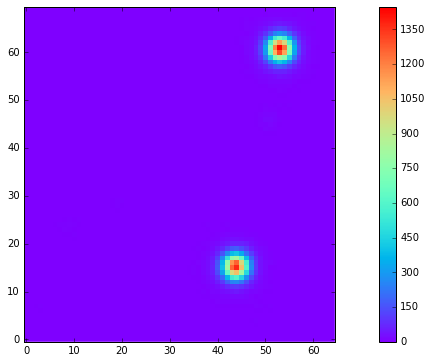

DIFF


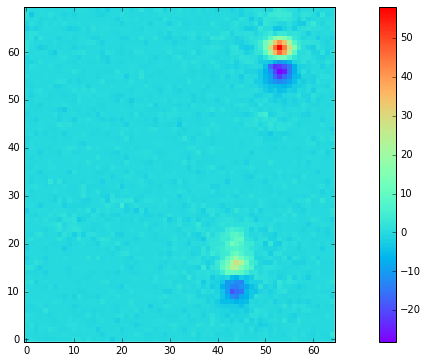

In [30]:
for _i in range(self.n_step):
    look(self.view_model(_i),x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
    print("max: ", np.max(self.view_model(_i)), "sum: ", np.sum(self.view_model(_i)))
print("SUM")
look(np.sum([self.view_model(_i) for _i in range(self.n_step)],axis=0),x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])

print("DIFF")
look(self.view_model(-1) - self.view_model(0),x_range=[x0, x0 + dx], y_range=[y0, y0 + dy],range=[-1e4,1e4])

In [31]:
# output_directory='/Users/sullivan/LSST/simulations/test6/dcr_with_psf/'
template_exposure_gen = self.generate_templates_from_model(obsid_range=[108,109,110],use_full=False,output_directory='temp')
im_arr = []
for exp in template_exposure_gen:
    im_arr.append(exp.getMaskedImage().getImage().getArray())

In [32]:
calexp_108 = self.butler.get("calexp", dataId={'visit': 108, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})
calexp_109 = self.butler.get("calexp", dataId={'visit': 109, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})
calexp_110 = self.butler.get("calexp", dataId={'visit': 110, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})

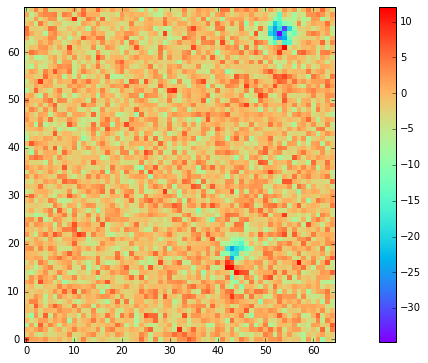

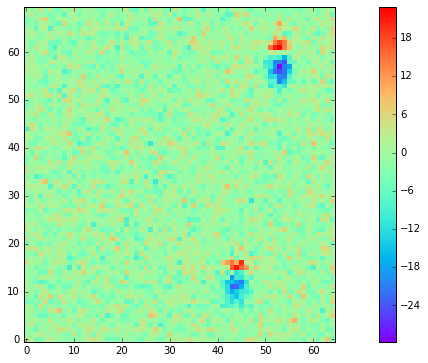

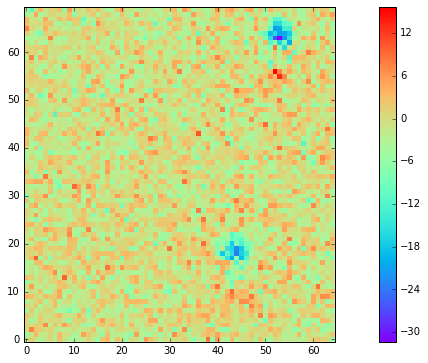

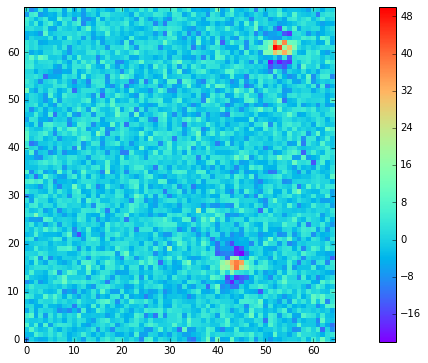

In [33]:
look(calexp_108.getMaskedImage().getImage().getArray() - im_arr[0],x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
look(calexp_109.getMaskedImage().getImage().getArray() - im_arr[1],x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
look(calexp_110.getMaskedImage().getImage().getArray() - im_arr[2],x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
look(calexp_110.getMaskedImage().getImage().getArray() - calexp_108.getMaskedImage().getImage().getArray(),
     x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])

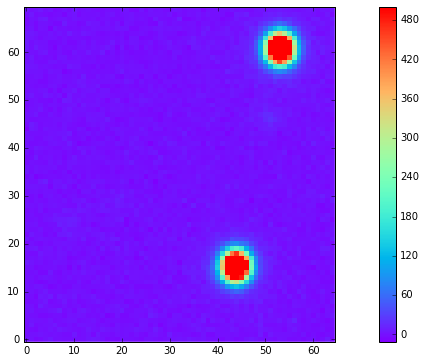

In [34]:
look(calexp_109.getMaskedImage().getImage().getArray(),range=[-5e2,5e2],x_range=[150, 215],y_range=[480,550])

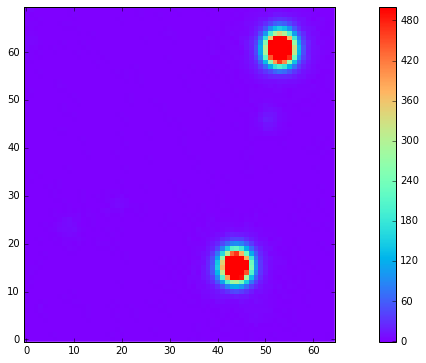

In [35]:
look(im_arr[2],range=[-5e2,5e2],x_range=[150, 215],y_range=[480,550])

In [36]:
psf_test = self.exposures[0].getPsf()
psf_test.computeApertureFlux(1)

0.09165123345261582

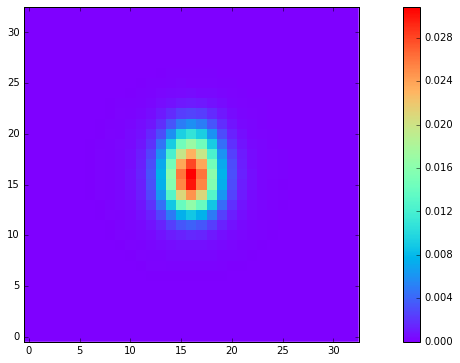

In [37]:
look(psf_test.computeKernelImage().getArray())

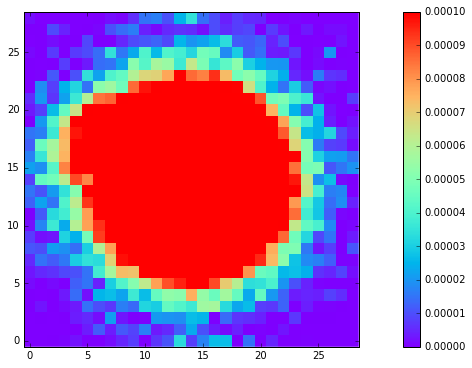

In [38]:
look(exp.getPsf().computeKernelImage().getArray(),range=[0,0.0001])